In [1]:
import math
import os

import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns
import csv
from numba import njit
from IPython.display import HTML


sns.set_style("whitegrid")
mpl.rcParams.update({
    'font.size':         17,
    'axes.edgecolor':   'black',
    'axes.labelcolor':  'black',
    'xtick.color':      'black',
    'ytick.color':      'black',
    'axes.facecolor':   'none' ,
    'figure.facecolor': 'none'
})
mpl.rcParams.update({"animation.html":"jshtml"})

In [2]:
# Energy difference function for both Glauber and Kawasaki dynamics
@njit
def delta_e(lattice, x, y, h):
    item = lattice[x][y]

    delta_e = - 2 * item * (lattice[(x+1) % 50][y] + lattice[(x-1)%50][y] +
                          lattice[x][(y+1)%50] + lattice[x][(y-1)%50]) - 2*h*item
    return delta_e

@njit
def magnetisation(lattice):
    return np.sum(lattice)

def stag_magnetisation(lattice):
    mag = 0
    for y in range(50):
        for x in range(50):
            mag += (-1)**(x+y) * lattice[y,x]
    return mag


In [10]:
# Choose a random spin and flip it based on the difference in energy between original and unflipped state
@njit
def flip(lattice, h):
    row_index = random.randint(0,49)
    column_index = random.randint(0,49)

    flipped_item = -1 * lattice[row_index][column_index]
    delta = delta_e(lattice, row_index, column_index, h)

    if delta <= 0:
        lattice[row_index][column_index] = flipped_item
    else:
        if np.random.random() < np.exp(- delta):
            lattice[row_index][column_index] = flipped_item
    return lattice


In [11]:
def create_video(frame_number, h):
    mpl.rcParams.update({"axes.grid" : False})
    global lattice
    lattice = np.random.choice([1,-1],(50,50))
    fig = plt.figure(figsize= (8,8))
    plot = plt.imshow(lattice)

    def init_ani():
        global lattice
        plot.set_array(lattice)
        return plot,

    def animate(i):
        global lattice
        for _ in range(2500):
            lattice = flip(lattice, h)
        plot.set_array(lattice)
        fig.suptitle(f"Anti-ferromagnet  h = {h}, # sweeps = {i}", y=0.95)
        return plot,


    ani = animation.FuncAnimation(fig, animate, frames=frame_number, init_func=init_ani, interval=40, blit=True)
    plt.close()


    return HTML(ani.to_jshtml())

In [13]:
%%time
ani = create_video(100, 1)
ani

CPU times: total: 15.9 s
Wall time: 28 s


In [16]:
%%time
ani = create_video(100, -1)
ani

CPU times: total: 19.6 s
Wall time: 34 s


CPU times: total: 19.4 s
Wall time: 33.6 s


In [18]:
def calculate_energy(lattice, h):
    return  np.sum(np.roll(lattice, 1, axis = 1) * lattice) - np.sum(np.roll(lattice, 1, axis = 0) * lattice) \
            + h * magnetisation(lattice)


In [19]:
%%time
#lattice = np.full(shape=(50, 50), fill_value=-1)
sweep = 2500


hs = np.arange(0,10.1,0.5)
temps = np.round(hs, decimals=1)

with open("data.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["h", "mag", "stag_mag", "energy"])

    for h in hs:
        lattice = np.random.choice([1,-1],(50,50))
        # for i in range(100*sweep):
        #     lattice = flip(lattice,h)
        for _ in range(1000):
            for _ in range(10*sweep):
                lattice = flip(lattice, h)
            writer.writerow([h, magnetisation(lattice), stag_magnetisation(lattice), calculate_energy(lattice, h)])


CPU times: total: 8min 38s
Wall time: 16min 29s


In [20]:
data = pd.read_csv('data.csv')

In [21]:

vars = data.groupby('h').var().reset_index()
means = data.groupby(['h']).mean().reset_index()


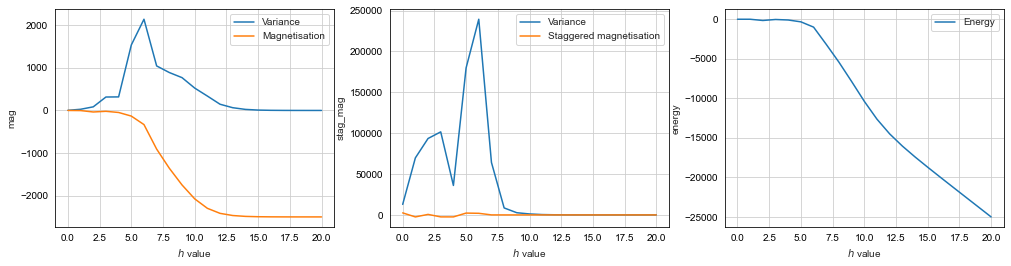

In [28]:
mpl.rcParams.update({"axes.grid" : True})
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(17,4))

sns.lineplot(vars["mag"], ax= ax1, label="Variance").set(xlabel="$h$ value")
sns.lineplot(means["mag"], ax= ax1, label="Magnetisation")

sns.lineplot(vars["stag_mag"], ax= ax2, label="Variance").set(xlabel="$h$ value")
sns.lineplot(means["stag_mag"], ax= ax2, label="Staggered magnetisation")

sns.lineplot(means["energy"], ax= ax3, label="Energy").set(xlabel="$h$ value")

ax1.legend()
ax2.legend()
ax3.legend()


#plt.subplots_adjust(hspace = 0.15, wspace = 0.25)
plt.show()

In [29]:
@njit
def flip2(lattice, h0, P, tau, t):
    row_index = random.randint(0,49)
    column_index = random.randint(0,49)

    flipped_item = -1 * lattice[row_index][column_index]
    delta = delta_e2(lattice, row_index, column_index, h0, P, tau, t)

    if delta <= 0:
        lattice[row_index][column_index] = flipped_item
    else:
        if np.random.random() < np.exp(- delta):
            lattice[row_index][column_index] = flipped_item
    return lattice

@njit
def delta_e2(lattice, y, x, h0, P, tau, t):
    item = lattice[y,x]

    delta_e = - 2 * item * (lattice[(y+1) % 50][x] + lattice[(y-1)%50][x] +
                            lattice[y][(x+1)%50] + lattice[y][(x-1)%50]) \
              - 2*item*h0*np.cos(2*np.pi*(x+1)/P)*np.cos(2*np.pi*(y+1)/P)*np.sin(2*np.pi*t/tau)
    return delta_e

In [32]:
def create_video2(frame_number, h0, P, tau):
    mpl.rcParams.update({"axes.grid" : False})
    global lattice
    lattice = np.random.choice([1,-1],(50,50))
    fig = plt.figure(figsize= (8,8))
    plot = plt.imshow(lattice)

    def init_ani():
        global lattice
        plot.set_array(lattice)
        return plot,

    def animate(i):
        global lattice
        for _ in range(2500):
            lattice = flip2(lattice, h0, P, tau, i)
        plot.set_array(lattice)
        fig.suptitle(f"Anti-ferromagnet  h = {h0}, P = {P}, # sweeps = {i}", y=0.95)
        return plot,


    ani = animation.FuncAnimation(fig, animate, frames=frame_number, init_func=init_ani, interval=40, blit=True)
    plt.close()


    return HTML(ani.to_jshtml())

In [34]:
ani = create_video2(frame_number=100, h0=10, P=25, tau=10000)
ani